In [1]:
import dask.array as da
import warnings

import dask.array as da
from sklearn.pipeline import Pipeline
from dask_ml.model_selection import train_test_split
from dask_ml.model_selection import GridSearchCV
from dask_ml.decomposition import PCA
from dask_ml.preprocessing import PolynomialFeatures
from dask_ml.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np
import pandas
from toolz.curried import groupby, valmap, pipe, pluck, merge_with, merge
from toolz.curried import map as fmap

from pymks.fmks.data.elastic_fe import solve
from pymks.fmks.data.multiphase import generate

from pymks.fmks.plot import plot_microstructures
from pymks.fmks.bases.primitive import PrimitiveTransformer
from pymks.fmks.correlations import TwoPointCorrelation, FlattenTransformer
from dask.distributed import Client, progress
import time
from mpl_toolkits import mplot3d
%matplotlib notebook


In [2]:
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
da.random.seed(10)
np.random.seed(10)

tmp = [
    generate(shape=(700, 101, 101,101), grain_size=x, volume_fraction=(0.5, 0.2,0.3), chunks=(5), percent_variance=0.15)
    for x in [(15, 2,2), (2,2, 15), (7,7, 7), (9, 9,3), (9,9, 9), (2, 2,2)]
]
x_data_gen = da.concatenate(tmp)

In [4]:
x_data_gen

,Array,Chunk
Bytes,34.62 GB,41.21 MB
Shape,"(4200, 101, 101, 101)","(5, 101, 101, 101)"
Count,2520 Tasks,840 Chunks
Type,int64,numpy.ndarray


In [5]:
print(x_data_gen.shape)
print(x_data_gen.chunks)


(4200, 101, 101, 101)
((5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.159011 to fit


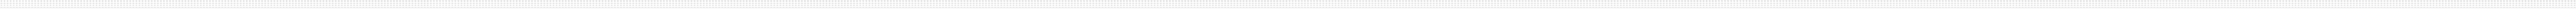

In [6]:
x_data_gen.visualize()

In [7]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:39595 Dashboard: http://127.0.0.1:40293/status,Cluster Workers: 4 Cores: 8 Memory: 33.59 GB


In [8]:
# client = Client( threads_per_worker=2,
#                 n_workers=2, memory_limit='8GB')
# client

In [9]:
bl1 = Pipeline(steps=[
    ("discritize",PrimitiveTransformer(n_state=2, min_=0.0, max_=1.0)),
    ("Correlations",TwoPointCorrelation(periodic_boundary=True, cutoff=15,correlations=[(1,1)])),
    ('flatten', FlattenTransformer()),  
    ('reducer',PCA(n_components=3))])

In [10]:
tic = time.time()
b=bl1.fit(x_data_gen)
toc = time.time()
print(tic-toc)
print(b)

-436.52669644355774
Pipeline(memory=None,
         steps=[('discritize',
                 PrimitiveTransformer(chunks=None, max_=1.0, min_=0.0,
                                      n_state=2)),
                ('Correlations',
                 TwoPointCorrelation(correlations=[(1, 1)], cutoff=15,
                                     periodic_boundary=True)),
                ('flatten', FlattenTransformer()),
                ('reducer',
                 PCA(copy=True, iterated_power=0, n_components=3,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False))],
         verbose=False)


In [11]:
tic = time.time()
b=bl1.transform(x_data_gen).compute()
toc = time.time()
print(tic-toc)
print(b)

-404.89462995529175
[[  0.99539708  -0.33182275  -0.19674994]
 [ 19.06473627  -0.33633141  -0.18403513]
 [  6.95527436  -0.33256639  -0.19346874]
 ...
 [ 12.6063189   -0.39043385   0.04124354]
 [-13.06000129  -0.38787923   0.04035128]
 [  2.77842766  -0.39007687   0.04003067]]


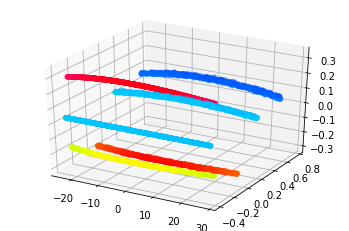

In [12]:
fig = plt.figure()
ax = plt.axes(projection="3d")

# z_line = np.linspace(0, 15, 1000)
# x_line = np.cos(z_line)
# y_line = np.sin(z_line)
# ax.plot3D(x_line, y_line, z_line, 'gray')

z_points = b[:,2]
x_points = b[:,0]
y_points = b[:,1]
ax.scatter3D(x_points, y_points, z_points, c=z_points, cmap='hsv');

plt.show()